**Simple Behavior Cloning**

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
print("Cuda: ", torch.cuda.is_available())

# Reading dataset - lib utilities
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt

Cuda:  True


In [2]:
# Read the data
csv_folder = "csv/90close"

demos = []
for i in glob.glob(os.path.join(csv_folder, "*.csv")):
    data = pd.read_csv(i, usecols=range(6, 12))
    data = np.array(data)
    demos.append(data)
    print(data.shape)
print(f"Number of demos: {len(demos)}")

(118, 6)
(113, 6)
(106, 6)
(91, 6)
(98, 6)
(102, 6)
(97, 6)
(88, 6)
(93, 6)
(102, 6)
(111, 6)
(96, 6)
(104, 6)
(111, 6)
(130, 6)
(108, 6)
(116, 6)
(92, 6)
(94, 6)
(85, 6)
(106, 6)
Number of demos: 21


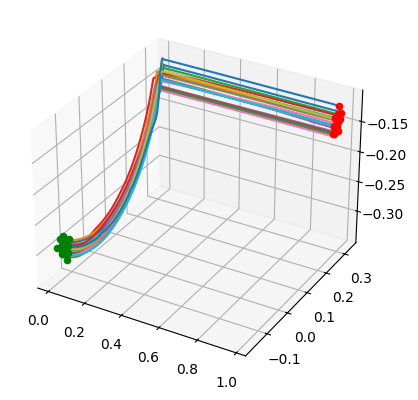

In [3]:
# visualize the data
ax = plt.figure().add_subplot(projection='3d')
for i in demos:
    x, y, z = i[:, 0], i[:, 1], i[:, 2] 
    ax.plot(x, y, z)
    ax.scatter(x[0], y[0], z[0], c='g')
    ax.scatter(x[-1], y[-1], z[-1], c='r')

In [4]:
# Define state and actions
states = demos[0][:len(demos[0])-1, :]
actions = demos[0][1:, :]

print(states.shape)
print(actions.shape)

(117, 6)
(117, 6)


In [5]:
# Create a custom dataset
class ExpertDataset(Dataset):
    def __init__(self, states, actions):
        self.states = torch.FloatTensor(states)
        self.actions = torch.FloatTensor(actions)
    
    def __len__(self):
        return len(self.states)
    
    def __getitem__(self, idx):
        return self.states[idx], self.actions[idx]

In [6]:
# Define the neural network model
class BehaviorCloneNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(BehaviorCloneNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  
        return x

In [7]:
# Create dataset and dataloader
dataset = ExpertDataset(states, actions)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
print(dataloader)


In [8]:
# Initialize the model, loss function, and optimizer
model = BehaviorCloneNet(states.shape[1], actions.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [9]:
# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for batch_states, batch_actions in dataloader:
        # Forward pass
        outputs = model(batch_states)
        loss = criterion(outputs, batch_actions)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/100], Loss: 1.5363
Epoch [2/100], Loss: 1.2948
Epoch [3/100], Loss: 1.1177
Epoch [4/100], Loss: 0.8102
Epoch [5/100], Loss: 0.5218
Epoch [6/100], Loss: 0.3355
Epoch [7/100], Loss: 0.1482
Epoch [8/100], Loss: 0.0827
Epoch [9/100], Loss: 0.0677
Epoch [10/100], Loss: 0.0335
Epoch [11/100], Loss: 0.0402
Epoch [12/100], Loss: 0.0393
Epoch [13/100], Loss: 0.0481
Epoch [14/100], Loss: 1.2836
Epoch [15/100], Loss: 0.0237
Epoch [16/100], Loss: 0.0321
Epoch [17/100], Loss: 0.0497
Epoch [18/100], Loss: 0.0329
Epoch [19/100], Loss: 0.0357
Epoch [20/100], Loss: 0.0371
Epoch [21/100], Loss: 0.0193
Epoch [22/100], Loss: 0.0359
Epoch [23/100], Loss: 0.0366
Epoch [24/100], Loss: 0.0178
Epoch [25/100], Loss: 0.0119
Epoch [26/100], Loss: 0.0199
Epoch [27/100], Loss: 0.0239
Epoch [28/100], Loss: 0.0150
Epoch [29/100], Loss: 0.0144
Epoch [30/100], Loss: 0.0103
Epoch [31/100], Loss: 0.0133
Epoch [32/100], Loss: 0.0146
Epoch [33/100], Loss: 0.0133
Epoch [34/100], Loss: 0.0098
Epoch [35/100], Loss: 0

In [14]:
# Use the trained model to make predictions
new_states = torch.tensor(demos[1][0], dtype=torch.float32)

print(f"Input Shape: {new_states.shape}")

model.load_state_dict(torch.load("90close_model.pth"))
model.eval()
predicted_actions = []
with torch.no_grad():
    for i in range(0, 100):
        predictions = model(new_states)
        new_states = predictions
        predicted_actions.append(np.array(predictions))


Input Shape: torch.Size([6])


100


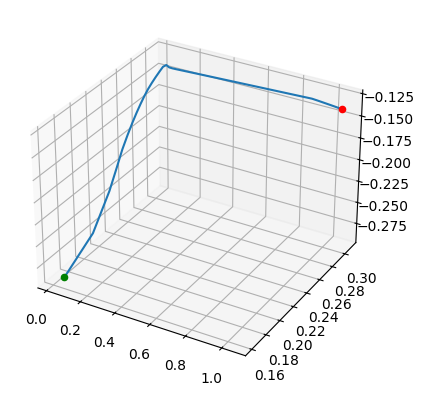

In [11]:
# Visualize the model output
print(len(predicted_actions))
predicted_actions = np.array(predicted_actions)
ax = plt.figure().add_subplot(projection='3d')
x, y, z = predicted_actions[:, 0], predicted_actions[:, 1], predicted_actions[:, 2]
ax.plot(x, y, z)
ax.scatter(x[0], y[0], z[0], c='g')
ax.scatter(x[-1], y[-1], z[-1], c='r')

In [18]:
# save the model
torch.save(model.state_dict(), "90close_model.pth")